In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR

# 1.데이터셋 준비

In [2]:
df = pd.read_csv('/content/시계열 분석 데이터 통합 (1).csv')
merged_df = pd.DataFrame(df)
merged_df.head()

,Month,Average_Close,GPRHC_CHN
0,2013-01-01,439347.826087,0.46
1,2013-02-01,425000.000000,0.52
2,2013-03-01,425000.000000,0.38
3,2013-04-01,425000.000000,0.58
4,2013-05-01,413260.869565,0.33


In [5]:
# 1차 차분 수행
merged_df["Diff_Average_Close"] = merged_df["Average_Close"].diff().dropna()
merged_df["Diff_GPRHC_CHN"] = merged_df["GPRHC_CHN"].diff().dropna()

# 정상성 검정
adf_close = adfuller(merged_df["Diff_Average_Close"].dropna())[1]
adf_gprc = adfuller(merged_df["Diff_GPRHC_CHN"].dropna())[1]

print(f"ADF Test p-value for Diff_Average_Close: {adf_close}")
print(f"ADF Test p-value for Diff_GPRHC_CHN: {adf_gprc}")

ADF Test p-value for Diff_Average_Close: 0.15150309226048359
ADF Test p-value for Diff_GPRHC_CHN: 5.861242515287659e-13


In [6]:
#Average_Close 2차 차분 수행
merged_df["Diff2_Average_Close"] = merged_df["Diff_Average_Close"].diff().dropna()

# 2차 차분에 대해 ADF 테스트 수행
adf_close_2nd = adfuller(merged_df["Diff2_Average_Close"].dropna())[1]

print(f"ADF Test p-value for Diff2_Average_Close: {adf_close_2nd}")

ADF Test p-value for Diff2_Average_Close: 1.4011659423543697e-13


In [7]:
display(merged_df)

,Month,Average_Close,GPRHC_CHN,Diff_Average_Close,Diff_GPRHC_CHN,Diff2_Average_Close
0,2013-01-01,439347.826087,0.46,NaN,NaN,NaN
1,2013-02-01,425000.000000,0.52,-14347.826087,0.06,NaN
2,2013-03-01,425000.000000,0.38,0.000000,-0.14,14347.826087
3,2013-04-01,425000.000000,0.58,0.000000,0.20,0.000000
4,2013-05-01,413260.869565,0.33,-11739.130435,-0.25,-11739.130435
...,...,...,...,...,...,...
138,2024-07-01,456304.347800,0.54,-3037.757463,-0.22,28620.137274
139,2024-08-01,480886.363636,0.70,24582.015836,0.16,27619.773300
140,2024-09-01,528105.263158,0.81,47218.899522,0.11,22636.883685
141,2024-10-01,532972.222222,0.83,4866.959064,0.02,-42351.940457


#2.데이터 시각화

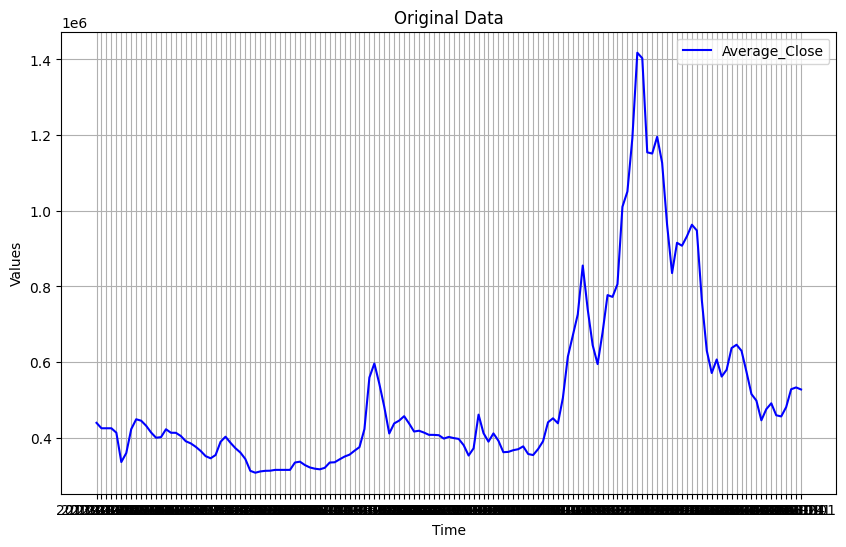

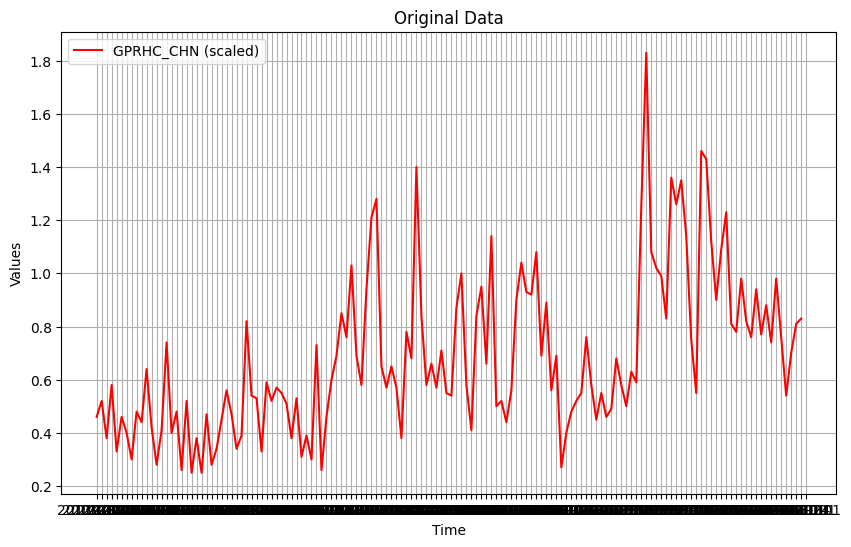

In [8]:
# 원본 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df["Month"], merged_df["Average_Close"], label="Average_Close", color="blue")
plt.legend()
plt.title("Original Data")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(merged_df["Month"], merged_df["GPRHC_CHN"], label="GPRHC_CHN (scaled)", color="red")
plt.legend()
plt.title("Original Data")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(True)
plt.show()

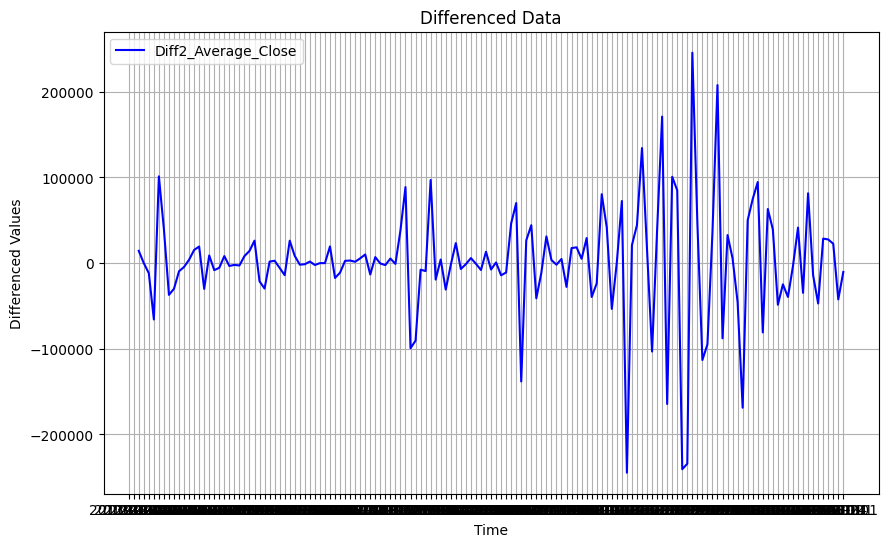

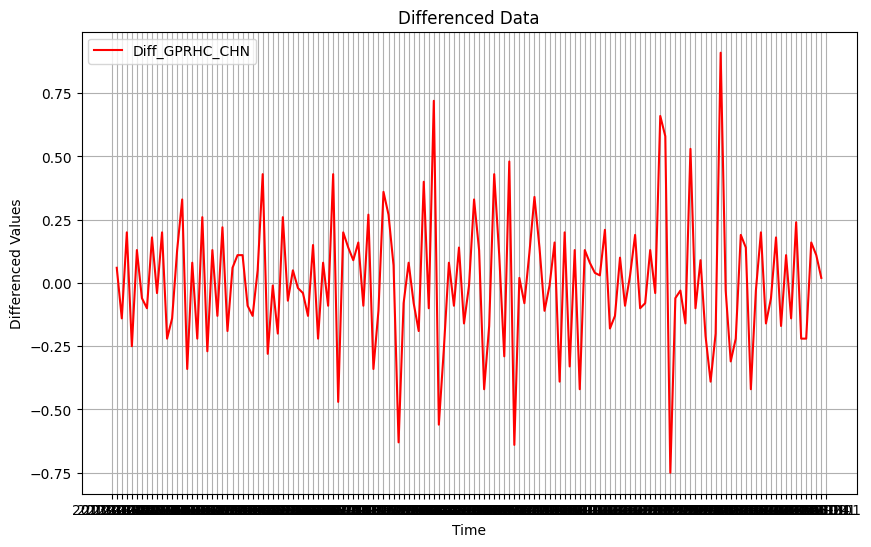

In [9]:
# 차분 데이터 시각화
plt.figure(figsize=(10, 6))
plt.plot(merged_df["Month"], merged_df["Diff2_Average_Close"], label="Diff2_Average_Close", color="blue")
plt.legend()
plt.title("Differenced Data")
plt.xlabel("Time")
plt.ylabel("Differenced Values")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(merged_df["Month"], merged_df["Diff_GPRHC_CHN"], label="Diff_GPRHC_CHN", color="red")
plt.legend()
plt.title("Differenced Data")
plt.xlabel("Time")
plt.ylabel("Differenced Values")
plt.grid(True)
plt.show()

#3.Granger인과검정

In [10]:
# Granger 검정에 사용할 데이터 (Diff_GPRHC_CHN, Diff2_Average_Close 열만 사용)
granger_data = merged_df[["Diff_GPRHC_CHN", "Diff2_Average_Close"]].dropna()

# 데이터 크기에 따라 maxlag 설정
maxlag = max(1, (len(granger_data) - 1) // 3)

# Granger 검정을 위한 결과 저장 DataFrame 초기화
cols = ["Diff_GPRHC_CHN", "Diff2_Average_Close"]
df_pairs = pd.DataFrame(
    data=np.zeros((len(cols), len(cols))),
    columns=["X_" + x for x in cols],
    index=["Y_" + x for x in cols]
)

# Granger 검정 실행
for col_i, col in enumerate(cols):
    for idx_i, idx in enumerate(cols):
        # Granger 검정 수행
        outs = grangercausalitytests(granger_data[[col, idx]], maxlag=maxlag, verbose=False)

        # 최소 P-value 저장
        pval_min = np.min([round(outs[x][0]["ssr_chi2test"][1], 4) for x in range(1, maxlag + 1)])
        df_pairs.iloc[idx_i, col_i] = pval_min

# 결과 출력
print(df_pairs)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


                       X_Diff_GPRHC_CHN  X_Diff2_Average_Close
Y_Diff_GPRHC_CHN                    1.0                    0.0
Y_Diff2_Average_Close               0.0                    1.0


#4.Cointegration test

In [11]:
# 공적분 검정 함수 정의
def calc_sig_dist(df, cols):
    # Johansen 공적분 검정 수행
    out = coint_johansen(df[cols], det_order=1, k_ar_diff=1)

    # 공적분 검정 결과 (Trace 통계량)
    stats = [round(x, 2) for x in out.lr1]
    # 유의 수준(5%)에 대한 임계값
    sigs = [round(x, 2) for x in out.cvt[:, 1]]

    # 각 통계량이 유의 수준을 초과하는지 여부 계산
    yns = [x > y for x, y in zip(stats, sigs)]

    # 평균적 차이 계산
    dist = np.mean(np.array(stats) - np.array(sigs))

    # 결과 출력
    print('stats: ', stats)
    print('sig-level: ', sigs)
    print('significant_yn: ', yns)
    print('dist: ', round(dist, 2))

# 데이터 전처리: 결측값 제거
merged_df_cleaned = merged_df.dropna(subset=["Diff_GPRHC_CHN", "Diff2_Average_Close"])

# 공적분 검정에 사용할 열 선택
columns_to_test = ["Diff_GPRHC_CHN", "Diff2_Average_Close"]

# 공적분 검정 실행
calc_sig_dist(merged_df_cleaned, columns_to_test)

stats:  [231.67, 93.52]
sig-level:  [18.4, 3.84]
significant_yn:  [True, True]
dist:  151.48


#5.Test data, Train data 분리

In [13]:
# 데이터프레임에서 필요한 두 열 선택
data = merged_df[['Diff_GPRHC_CHN', 'Diff2_Average_Close']]

# 데이터 크기 기반으로 train/test 분리
train_size = int(len(data) * 0.8)  # 80% 길이 계산

# Train과 Test 데이터 나누기
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

# 결과 출력
print("Train 데이터 크기:", train_data.shape)
print("Test 데이터 크기:", test_data.shape)

# 필요시 train_data와 test_data를 csv 파일로 저장
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

Train 데이터 크기: (114, 2)
Test 데이터 크기: (29, 2)


#6.ADF검정

In [14]:
# ADF 검정을 수행하는 함수 정의
def get_adf(df, col):
    # ADF 검정 수행
    adf_result = adfuller(df[col], autolag='AIC')

    # 결과를 데이터프레임으로 변환
    adf_df = pd.DataFrame(
        {
            col: [adf_result[0], adf_result[1], adf_result[2], adf_result[3]],
            'stat': ['ADF Statistic', 'p-value', 'usedlag', 'nobs']
        }
    ).set_index('stat').T

    # 유의 수준 임계값 추가
    sig = pd.DataFrame(
        {col: adf_result[4]},
        index=['1%', '5%', '10%']
    )

    # 결과와 유의 수준 병합
    adf_full = pd.concat([adf_df, sig.T], axis=0)

    # 값 소수점 둘째 자리까지 반올림
    adf_full = adf_full.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    return adf_full

# 데이터 준비 (merged_df 정의)
merged_df_cleaned = merged_df.dropna(subset=["Diff_GPRHC_CHN", "Diff2_Average_Close"])

# ADF 검정을 수행할 열 지정
columns_to_test = ["Diff_GPRHC_CHN", "Diff2_Average_Close"]

# 모든 열에 대해 ADF 검정 실행 및 결과 저장
results = {}
for col in columns_to_test:
    results[col] = get_adf(merged_df_cleaned, col)

# 결과 출력
for col, result in results.items():
    print(f"Results for {col}:")
    print(result)
    print("\n")


Results for Diff_GPRHC_CHN:
                ADF Statistic  p-value  usedlag   nobs    1%    5%   10%
Diff_GPRHC_CHN          -8.21      0.0      4.0  135.0   NaN   NaN   NaN
Diff_GPRHC_CHN            NaN      NaN      NaN    NaN -3.48 -2.88 -2.58


Results for Diff2_Average_Close:
                     ADF Statistic  p-value  usedlag   nobs    1%    5%   10%
Diff2_Average_Close          -8.47      0.0      9.0  130.0   NaN   NaN   NaN
Diff2_Average_Close            NaN      NaN      NaN    NaN -3.48 -2.88 -2.58




<ipython-input-14-4cd04b42628b>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adf_full = adf_full.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)
<ipython-input-14-4cd04b42628b>:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adf_full = adf_full.applymap(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)


#7.VAR 모델

In [24]:
# 1. 필요한 두 열 선택
data = train_data[['Diff_GPRHC_CHN', 'Diff2_Average_Close']]

# 2. 결측치 처리 (평균값으로 대체)
data_filled = data.fillna(data.mean())

# 결측치 처리 결과 확인
print("결측치 처리 전 데이터 크기:", data.shape)
print("결측치 처리 후 데이터 크기:", data_filled.shape)

# 3. VAR 모델 초기화
model = VAR(data_filled)

# 4. 최적의 시점(order) 선택
selected_lag = model.select_order(maxlags=15)
print("\n시차 선택 결과 (AIC, BIC, HQIC):")
print(selected_lag.summary())

# 각 정보 기준 출력
print(f"최적 시차 (AIC): {selected_lag.aic}")
print(f"최적 시차 (BIC): {selected_lag.bic}")
print(f"최적 시차 (HQIC): {selected_lag.hqic}")

# 최적 시차 결정 (AIC 기준)
optimal_lag = selected_lag.aic
print(f"\n최적 시차 (AIC 기준): {optimal_lag}")

# 5. 모델 학습
var_result = model.fit(optimal_lag)
print("\nVAR 모델 학습 결과 요약:")
print(var_result.summary())

# 6. 계수 행렬 출력
print("\n계수 행렬:")
coefficients = var_result.coefs  # 계수 행렬 추출
for i, coef in enumerate(coefficients, start=1):
    print(f"A_{i}:")
    print(pd.DataFrame(coef, columns=data_filled.columns, index=data_filled.columns))

결측치 처리 전 데이터 크기: (114, 2)
결측치 처리 후 데이터 크기: (114, 2)

시차 선택 결과 (AIC, BIC, HQIC):
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        19.58       19.63   3.192e+08       19.60
1        19.40       19.56   2.664e+08       19.46
2        19.08      19.35*   1.943e+08       19.19
3        19.06       19.43   1.892e+08       19.21
4        18.96       19.43   1.715e+08      19.15*
5        18.96       19.54   1.726e+08       19.20
6        19.04       19.72   1.867e+08       19.32
7        19.06       19.85   1.907e+08       19.38
8        19.13       20.02   2.048e+08       19.49
9        18.90       19.90   1.638e+08       19.31
10      18.81*       19.91  1.497e+08*       19.26
11       18.85       20.06   1.567e+08       19.34
12       18.91       20.22   1.667e+08       19.44
13       18.90       20.31   1.660e+08       19.47
14       18.96       20.48   1.776e+08       19.57
15

In [26]:
# BIC 기준 최적 시차 선택
optimal_lag_bic = selected_lag.bic
print(f"최적 시차 (BIC 기준): {optimal_lag_bic}")

# HQIC 기준 최적 시차 선택
optimal_lag_hqic = selected_lag.hqic
print(f"최적 시차 (HQIC 기준): {optimal_lag_hqic}")

# BIC를 기준으로 모델 학습
var_result_bic = model.fit(optimal_lag_bic)
print("\nBIC 기준 VAR 모델 학습 결과 요약:")
print(var_result_bic.summary())

# HQIC를 기준으로 모델 학습
var_result_hqic = model.fit(optimal_lag_hqic)
print("\nHQIC 기준 VAR 모델 학습 결과 요약:")
print(var_result_hqic.summary())

최적 시차 (BIC 기준): 2
최적 시차 (HQIC 기준): 4

BIC 기준 VAR 모델 학습 결과 요약:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Jan, 2025
Time:                     06:46:09
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.1680
Nobs:                     112.000    HQIC:                   19.0237
Log likelihood:          -1367.66    FPE:                1.65647e+08
AIC:                      18.9253    Det(Omega_mle):     1.51792e+08
--------------------------------------------------------------------
Results for equation Diff_GPRHC_CHN
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                          0.008564         0.022361            0.383           0.702
L1.Diff_GPRHC_CHN             -0.431351    

In [29]:
# 테스트 데이터 결측치 처리
test_data_cleaned = test_data.fillna(test_data.mean())

# BIC 모델 예측 (차분된 상태)
forecast_bic = var_result_bic.forecast(y=test_data_cleaned.values[-optimal_lag_bic:], steps=len(test_data_cleaned))

# HQIC 모델 예측 (차분된 상태)
forecast_hqic = var_result_hqic.forecast(y=test_data_cleaned.values[-optimal_lag_hqic:], steps=len(test_data_cleaned))

# 예측값을 데이터프레임으로 변환
forecast_bic_df = pd.DataFrame(forecast_bic, columns=test_data_cleaned.columns, index=test_data_cleaned.index)
forecast_hqic_df = pd.DataFrame(forecast_hqic, columns=test_data_cleaned.columns, index=test_data_cleaned.index)

# 변수별 RMSE 계산
rmse_bic = {}
rmse_hqic = {}

for col in test_data_cleaned.columns:
    rmse_bic[col] = np.sqrt(np.mean((forecast_bic_df[col] - test_data_cleaned[col]) ** 2))
    rmse_hqic[col] = np.sqrt(np.mean((forecast_hqic_df[col] - test_data_cleaned[col]) ** 2))

# 출력
print("BIC 모델 RMSE (변수별):")
for col, value in rmse_bic.items():
    print(f"{col}: {value}")

print("\nHQIC 모델 RMSE (변수별):")
for col, value in rmse_hqic.items():
    print(f"{col}: {value}")

BIC 모델 RMSE (변수별):
Diff_GPRHC_CHN: 0.26937633680732875
Diff2_Average_Close: 75209.60177928046

HQIC 모델 RMSE (변수별):
Diff_GPRHC_CHN: 0.26914078122925844
Diff2_Average_Close: 73524.34185272524


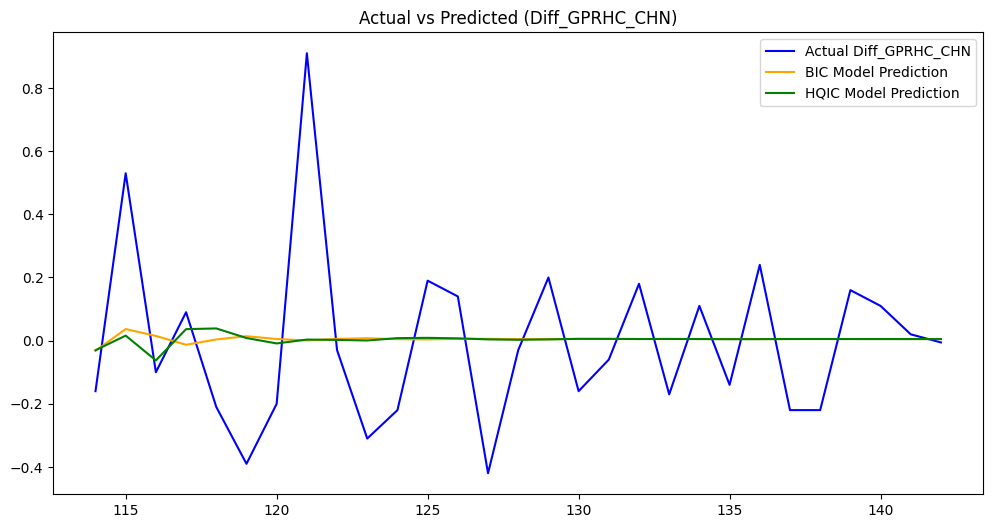

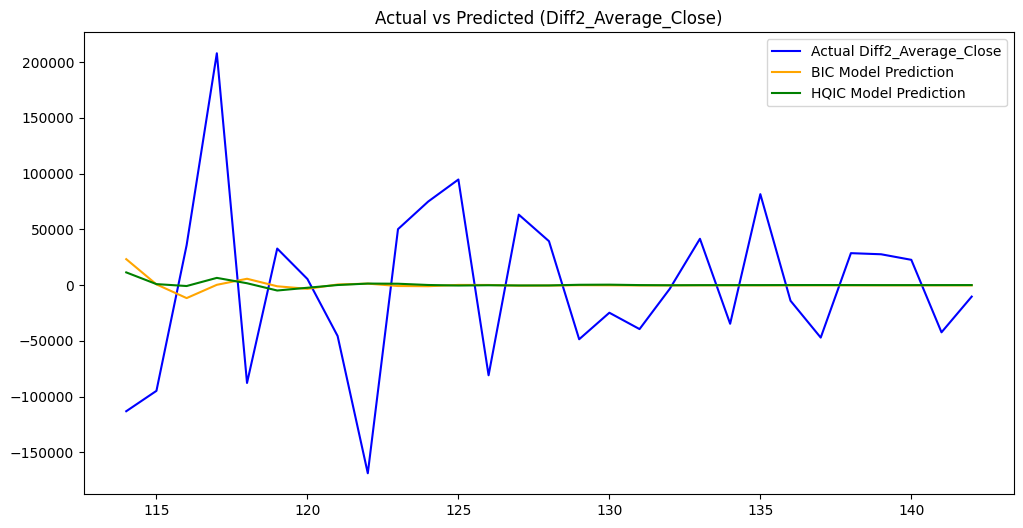

In [30]:
# 실제값과 두 모델의 예측값 시각화
plt.figure(figsize=(12, 6))
plt.plot(test_data_cleaned.index, test_data_cleaned['Diff_GPRHC_CHN'], label="Actual Diff_GPRHC_CHN", color='blue')
plt.plot(test_data_cleaned.index, forecast_bic[:, 0], label="BIC Model Prediction", color='orange')
plt.plot(test_data_cleaned.index, forecast_hqic[:, 0], label="HQIC Model Prediction", color='green')
plt.legend()
plt.title("Actual vs Predicted (Diff_GPRHC_CHN)")
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(test_data_cleaned.index, test_data_cleaned['Diff2_Average_Close'], label="Actual Diff2_Average_Close", color='blue')
plt.plot(test_data_cleaned.index, forecast_bic[:, 1], label="BIC Model Prediction", color='orange')
plt.plot(test_data_cleaned.index, forecast_hqic[:, 1], label="HQIC Model Prediction", color='green')
plt.legend()
plt.title("Actual vs Predicted (Diff2_Average_Close)")
plt.show()

#8.충격반응분석

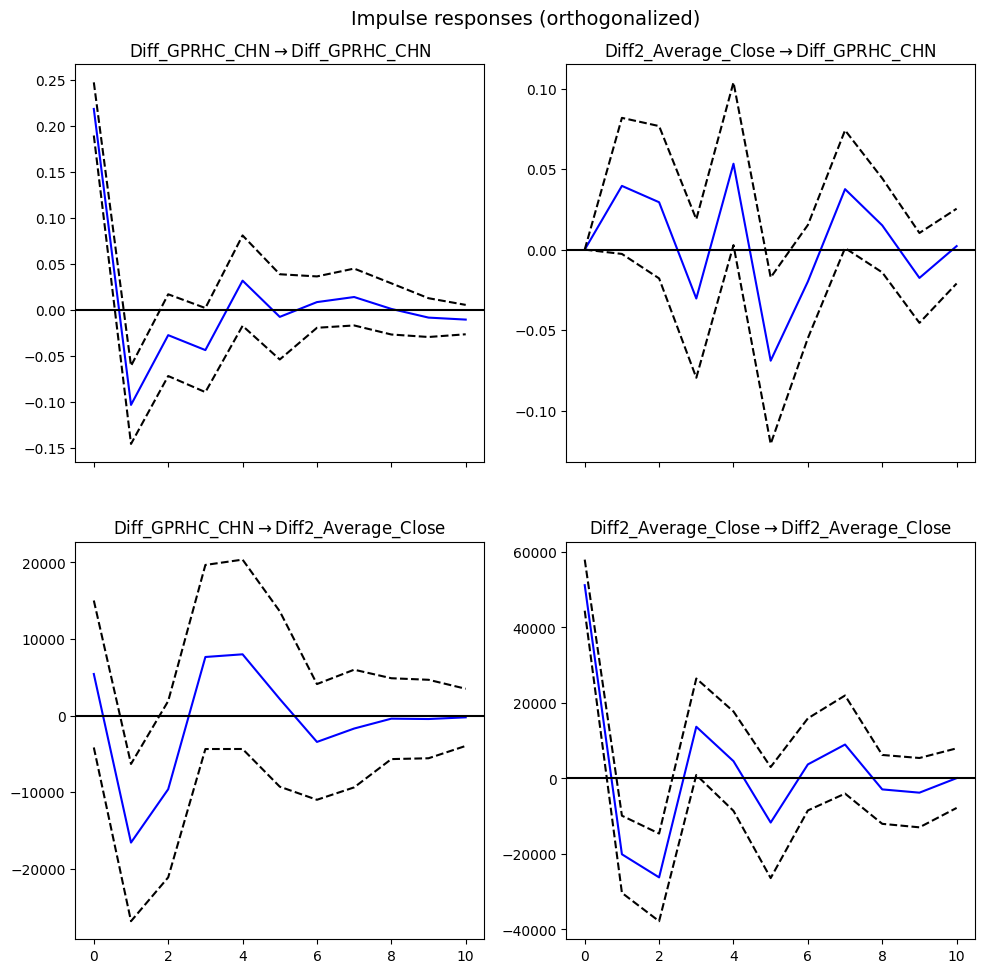

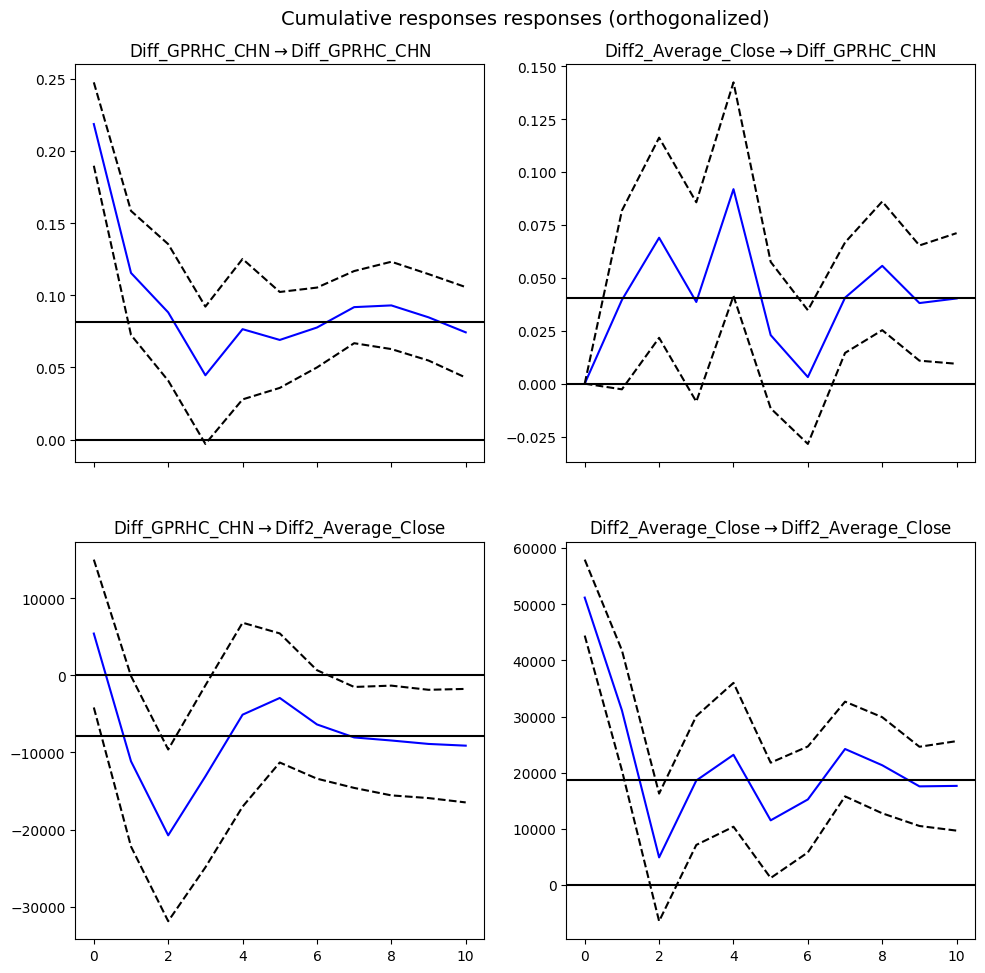

In [32]:
# HQIC 기준으로 학습된 VAR 모델 결과: var_result_hqic

# 충격 반응 분석 (Impulse Response Analysis)
irf = var_result_hqic.irf(10)  # 최대 10단계의 충격 반응 분석 수행

# 충격 반응 함수 시각화
irf.plot(orth=True)  # Cholesky 분해(Orthogonalization)를 사용하여 충격 분리
plt.show()

# 특정 변수에 대한 충격 반응 분석 (선택적으로 추가 분석)
irf.plot_cum_effects(orth=True)  # 누적 충격 반응(Cumulative Impulse Response)
plt.show()

In [34]:
# 충격 반응 함수 값 출력
irf_table = irf.irfs  # 충격 반응 함수 값 (3D 배열: 단계, 변수1, 변수2)

# 특정 변수의 충격 반응 데이터프레임으로 변환
irf_df = pd.DataFrame(irf_table[:, 0, :], columns=var_result_hqic.names)
irf_df.index.name = "Step"  # 단계 이름 설정
print(irf_df.head(10))  # 상위 10단계 결과 출력

      Diff_GPRHC_CHN  Diff2_Average_Close
Step                                     
0           1.000000         0.000000e+00
1          -0.491080         7.731324e-07
2          -0.139283         5.748279e-07
3          -0.184559        -5.935356e-07
4           0.120202         1.042163e-06
5          -0.000645        -1.348126e-06
6           0.048994        -3.878195e-07
7           0.046396         7.335687e-07
8          -0.001838         2.940445e-07
9          -0.029215        -3.437927e-07


#9.예측오차 분산분해

FEVD for Diff_GPRHC_CHN
     Diff_GPRHC_CHN  Diff2_Average_Close
0          1.000000             0.000000
1          0.973939             0.026061
2          0.960591             0.039409
3          0.948012             0.051988
4          0.909347             0.090653
5          0.850274             0.149726
6          0.845878             0.154122
7          0.830447             0.169553
8          0.827960             0.172040
9          0.824736             0.175264

FEVD for Diff2_Average_Close
     Diff_GPRHC_CHN  Diff2_Average_Close
0          0.011141             0.988859
1          0.091448             0.908552
2          0.096593             0.903407
3          0.104592             0.895408
4          0.117023             0.882977
5          0.114448             0.885552
6          0.116373             0.883627
7          0.114906             0.885094
8          0.114731             0.885269
9          0.114424             0.885576


None


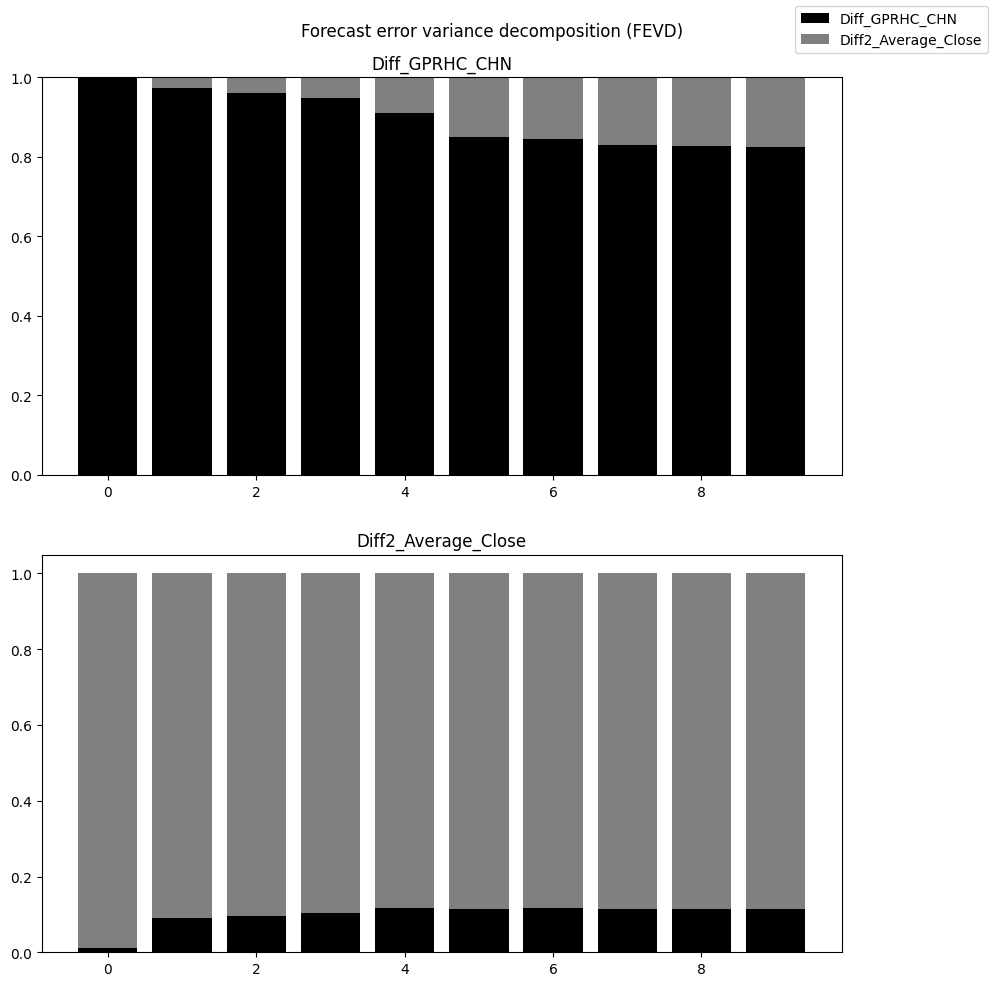

In [35]:
# HQIC 기준으로 학습된 VAR 모델 결과: var_result_hqic

# 예측 오차 분산 분해 (Forecast Error Variance Decomposition)
fevd = var_result_hqic.fevd(10)  # 최대 10단계까지 예측 오차 분산 분해 수행

# 분산 분해 결과 출력
print(fevd.summary())

# 분산 분해 결과 시각화
fevd.plot()
plt.show()